# Image Super-Resolution using U-Net

This notebook demonstrates how to build and train a U-Net model for image super-resolution.  
The goal is to take a low-resolution image (32x32) and generate a high-resolution version (128x128).

The U-Net architecture is well-suited for this task as it effectively captures both local and global features through its encoder-decoder structure with skip connections.

![Super Resolution Example](https://raw.githubusercontent.com/AshishJangra27/ai-projects/refs/heads/main/Image%20Enhancement%20with%20U-Net/img.png)


### 1. Setup and Imports

This cell imports all the necessary libraries for building and training the U-Net model, including Keras for model definition, OpenCV for image processing, and Matplotlib for visualization.

In [10]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import (
    Input, BatchNormalization, Activation, Dropout,
    Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
)
from keras.optimizers import Adam
import tensorflow as tf


2025-12-28 11:52:54.369479: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766922774.597958      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766922774.657952      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1766922775.182809      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766922775.182860      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1766922775.182863      55 computation_placer.cc:177] computation placer alr

### 2. U-Net Model Definition

This cell defines the U-Net model architecture for image super-resolution. The `unet_64to128` function creates a U-Net model that takes a 64x64x3 image as input and outputs a 128x128x3 image. It includes an encoder, a bottleneck, and a decoder with skip connections.

In [11]:
def unet_32to128(input_shape=(32, 32, 3), n_classes=3, final_activation='sigmoid', dropout_rate=0.05):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(16, (3,3), padding='same')(inputs)
    c1 = BatchNormalization()(c1); c1 = Activation('relu')(c1)
    c1 = Conv2D(16, (3,3), padding='same')(c1)
    c1 = BatchNormalization()(c1); c1 = Activation('relu')(c1)
    p1 = MaxPooling2D((2,2))(c1)  # 32 → 16

    c2 = Conv2D(32, (3,3), padding='same')(p1)
    c2 = BatchNormalization()(c2); c2 = Activation('relu')(c2)
    c2 = Conv2D(32, (3,3), padding='same')(c2)
    c2 = BatchNormalization()(c2); c2 = Activation('relu')(c2)
    p2 = MaxPooling2D((2,2))(c2)  # 16 → 8

    c3 = Conv2D(64, (3,3), padding='same')(p2)
    c3 = BatchNormalization()(c3); c3 = Activation('relu')(c3)
    c3 = Conv2D(64, (3,3), padding='same')(c3)
    c3 = BatchNormalization()(c3); c3 = Activation('relu')(c3)
    p3 = MaxPooling2D((2,2))(c3)  # 8 → 4

    c4 = Conv2D(128, (3,3), padding='same')(p3)
    c4 = BatchNormalization()(c4); c4 = Activation('relu')(c4)
    c4 = Conv2D(128, (3,3), padding='same')(c4)
    c4 = BatchNormalization()(c4); c4 = Activation('relu')(c4)
    p4 = MaxPooling2D((2,2))(c4)  # 4 → 2

    # Bottleneck
    c5 = Conv2D(256, (3,3), padding='same')(p4)
    c5 = BatchNormalization()(c5); c5 = Activation('relu')(c5)
    c5 = Conv2D(256, (3,3), padding='same')(c5)
    c5 = BatchNormalization()(c5); c5 = Activation('relu')(c5)

    # Decoder
    u6 = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Conv2D(128, (3,3), padding='same')(u6)
    u6 = BatchNormalization()(u6); u6 = Activation('relu')(u6)

    u7 = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same')(u6)
    u7 = concatenate([u7, c3])
    u7 = Conv2D(64, (3,3), padding='same')(u7)
    u7 = BatchNormalization()(u7); u7 = Activation('relu')(u7)

    u8 = Conv2DTranspose(32, (3,3), strides=(2,2), padding='same')(u7)
    u8 = concatenate([u8, c2])
    u8 = Conv2D(32, (3,3), padding='same')(u8)
    u8 = BatchNormalization()(u8); u8 = Activation('relu')(u8)

    u9 = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same')(u8)
    u9 = concatenate([u9, c1])
    u9 = Conv2D(16, (3,3), padding='same')(u9)
    u9 = BatchNormalization()(u9); u9 = Activation('relu')(u9)

    # Extra upsampling: 32 → 64 → 128
    u10 = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same')(u9)
    u11 = Conv2DTranspose(16, (3,3), strides=(2,2), padding='same')(u10)

    outputs = Conv2D(n_classes, (1,1), activation=final_activation)(u11)

    return Model(inputs, outputs)


### 3. Model Initialization and Compilation

This cell initializes the U-Net model with the specified input shape and number of classes. It then compiles the model using the Adam optimizer and mean absolute error (MAE) as the loss function. The input and output shapes are printed to verify the model architecture.

In [12]:
model = unet_32to128(input_shape=(32,32,3), n_classes=3)

print("Input shape :", model.input_shape)
print("Output shape:", model.output_shape)

model.compile(
    optimizer=Adam(1e-4),
    loss='mae'
)


2025-12-28 11:53:10.009281: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Input shape : (None, 32, 32, 3)
Output shape: (None, 128, 128, 3)


### Dataset Path Setup (CelebA)

In [13]:
base_dir = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba/'
imgs = os.listdir(base_dir)

print("Total images:", len(imgs))


Total images: 202599


### 4. Data Generator

This cell defines a data generator function `datagen` that loads and preprocesses images from the CelebA dataset. It resizes the images to 128x128 as ground truth and to 64x64 as low-resolution input, and normalizes the pixel values. The generator yields batches of low-resolution and high-resolution image pairs for training.

In [14]:
def datagen(batch_size):
    while True:
        x_batch, y_batch = [], []

        for _ in range(batch_size):
            idx = np.random.randint(0, len(imgs))
            img = cv.imread(base_dir + imgs[idx])
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = cv.resize(img, (128,128))

            x = cv.resize(img, (32,32)) / 255.0
            y = img / 255.0

            x_batch.append(x)
            y_batch.append(y)

        yield np.array(x_batch), np.array(y_batch)


### 5. Model Training (Short Run)

This cell trains the U-Net model for a small number of epochs (5) using the `datagen` function. This is a short run to quickly check if the model is training without errors.

In [15]:
batch_size = 32
steps_per_epoch = len(imgs) // batch_size

model.fit(
    datagen(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=5,
    verbose=1
)


Epoch 1/5
6331/6331 ━━━━━━━━━━━━━━━━━━━━ 2339s 368ms/step - loss: 0.0758
Epoch 2/5
6331/6331 ━━━━━━━━━━━━━━━━━━━━ 2361s 373ms/step - loss: 0.0413
Epoch 3/5
6331/6331 ━━━━━━━━━━━━━━━━━━━━ 2367s 374ms/step - loss: 0.0375
Epoch 4/5
6331/6331 ━━━━━━━━━━━━━━━━━━━━ 2368s 374ms/step - loss: 0.0360
Epoch 5/5
6331/6331 ━━━━━━━━━━━━━━━━━━━━ 2357s 372ms/step - loss: 0.0350


### 6. Model Training with Callbacks and Sample Saving

This cell trains the U-Net model for a longer duration (3 epochs) and includes custom callbacks. The `show_and_save_samples` function generates and saves sample super-resolved images at the end of each epoch, along with the original, ground truth, and low-resolution images for comparison. The `LambdaCallback` is used to execute this function after each epoch. The model checkpoints are also saved during training.

In [ ]:
def show_samples(model, n=5):
    fig, axes = plt.subplots(n, 4, figsize=(16, 4*n))

    for i in range(n):
        idx = np.random.randint(0, len(imgs))
        img = cv.imread(base_dir + imgs[idx])
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (128,128))

        lr = cv.resize(img, (32,32)) / 255.0
        pred = model.predict(lr[np.newaxis], verbose=0)[0]
        lr_up = cv.resize((lr*255).astype(np.uint8), (128,128))

        axes[i][0].imshow(img);   axes[i][0].set_title("Original")
        axes[i][1].imshow(img);   axes[i][1].set_title("GT 128×128")
        axes[i][2].imshow(lr_up); axes[i][2].set_title("Low-Res (32→128)")
        axes[i][3].imshow(pred);  axes[i][3].set_title("Prediction")

        for ax in axes[i]:
            ax.axis("off")

    plt.tight_layout()
    plt.show()


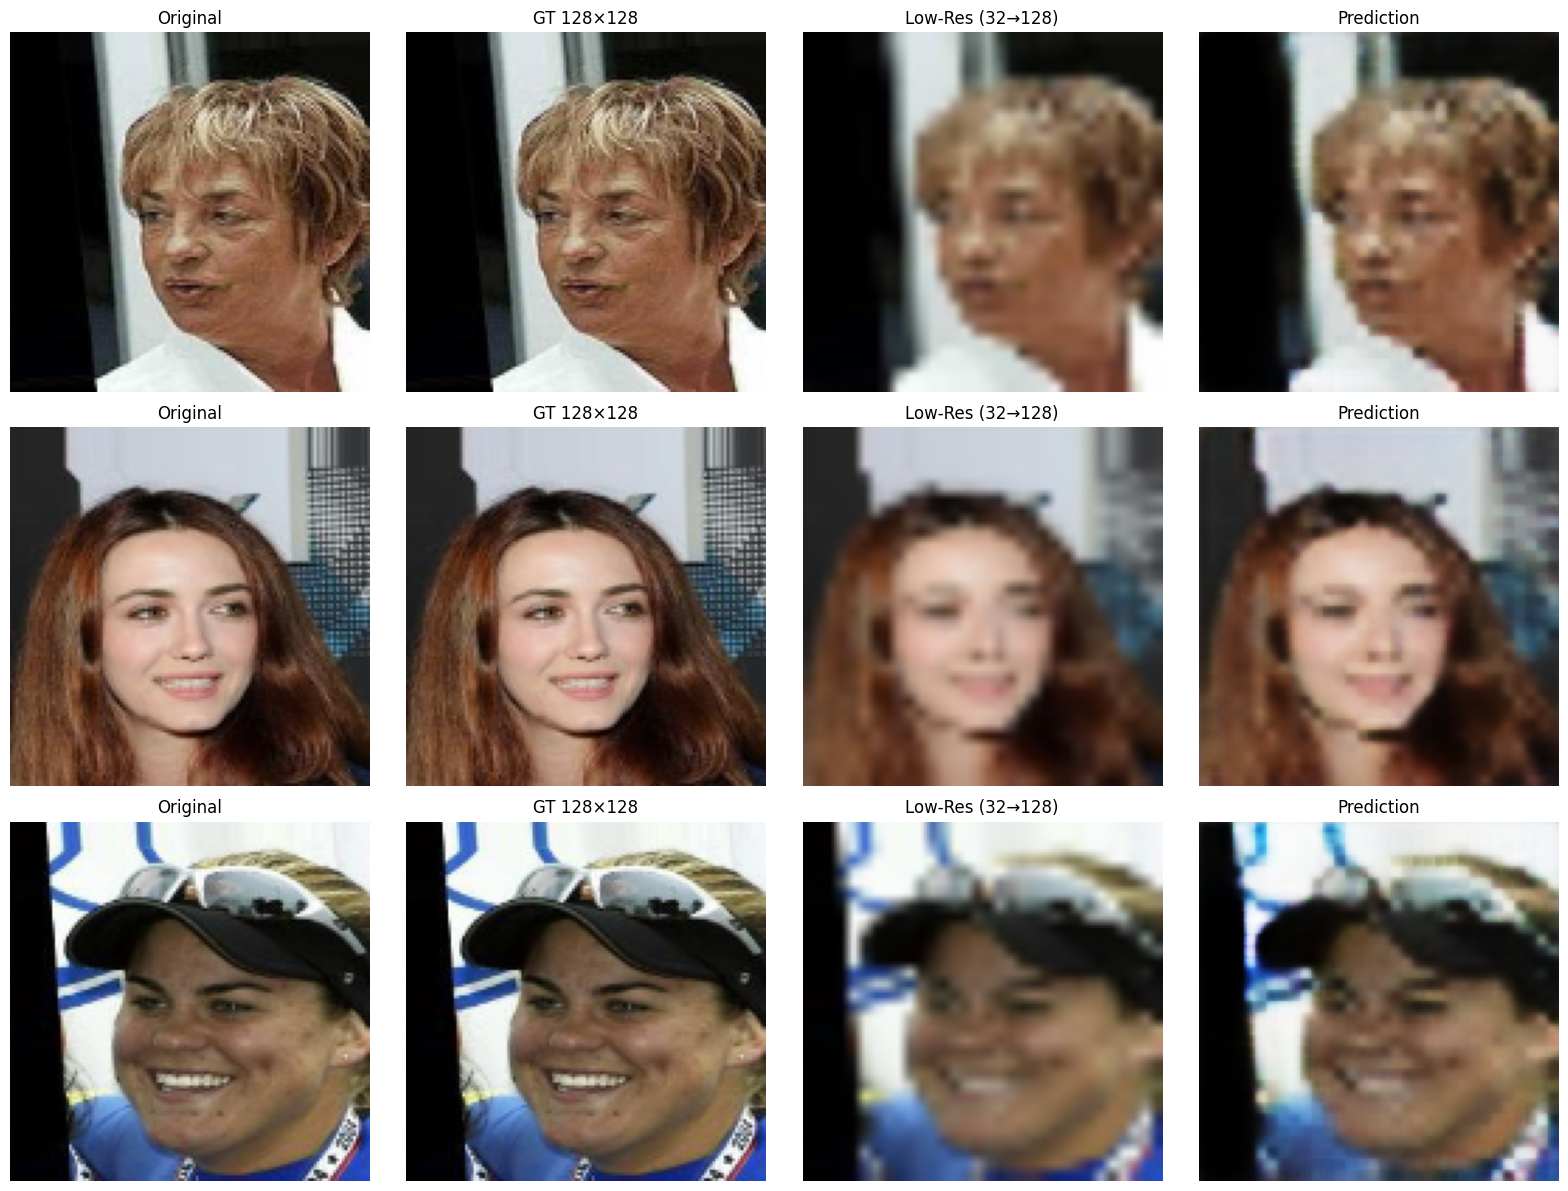

In [17]:
show_samples(model, n=3)


Epoch 1/3
6331/6331 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - loss: 0.0344
Epoch 1 samples:


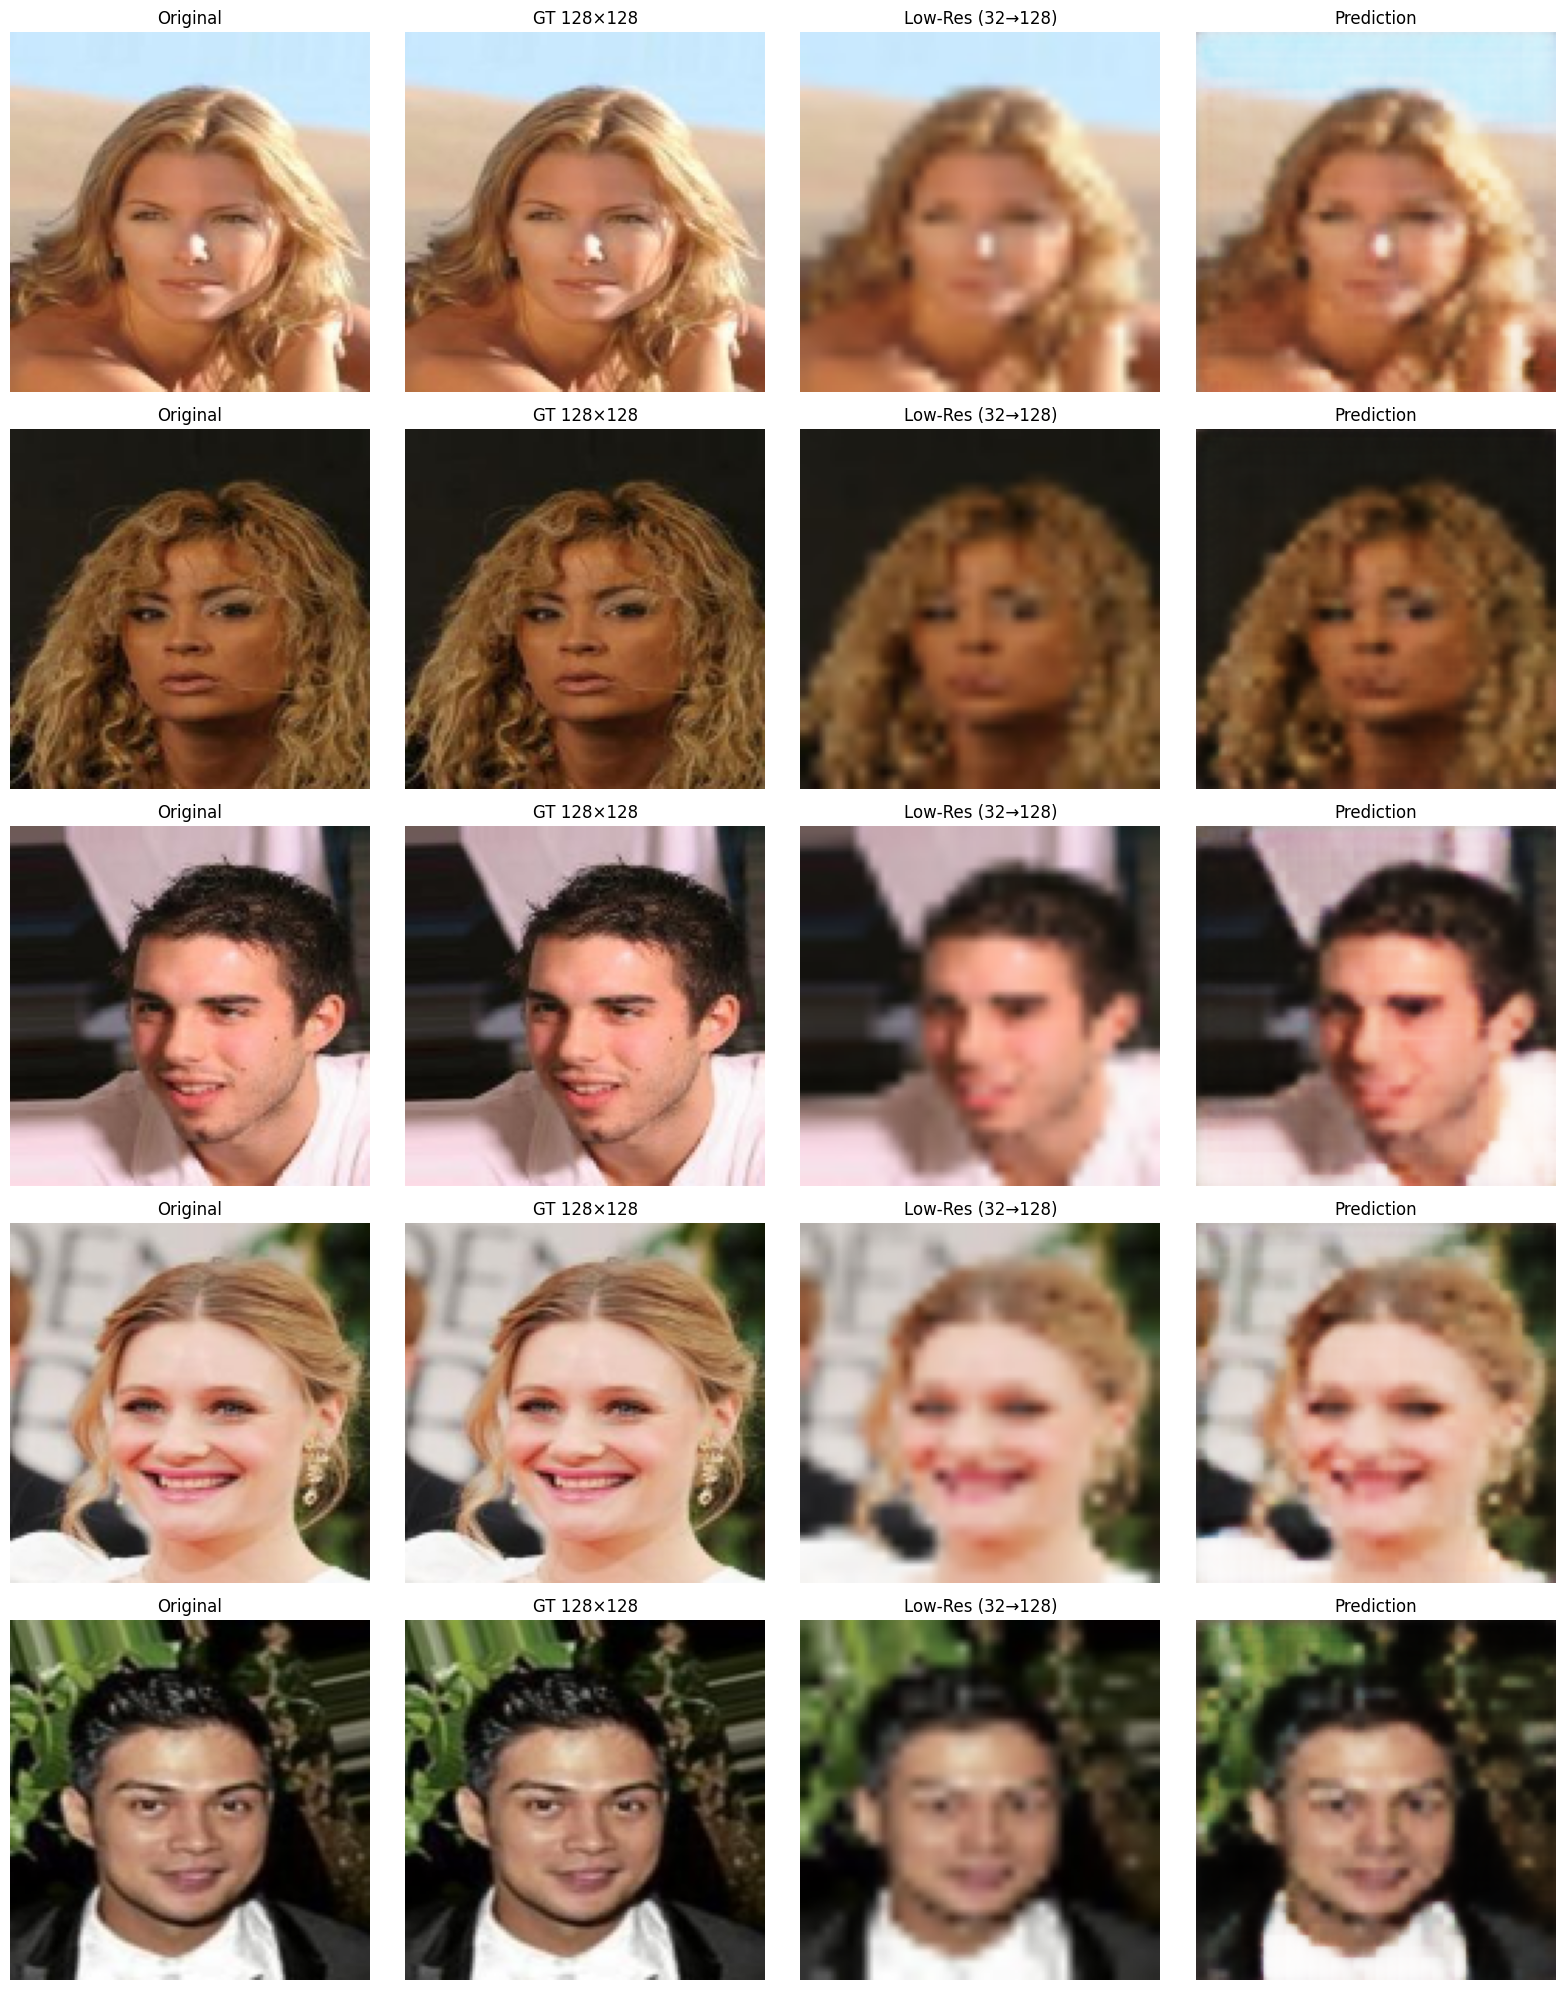

6331/6331 ━━━━━━━━━━━━━━━━━━━━ 2360s 373ms/step - loss: 0.0344
Epoch 2/3
6331/6331 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - loss: 0.0339
Epoch 2 samples:


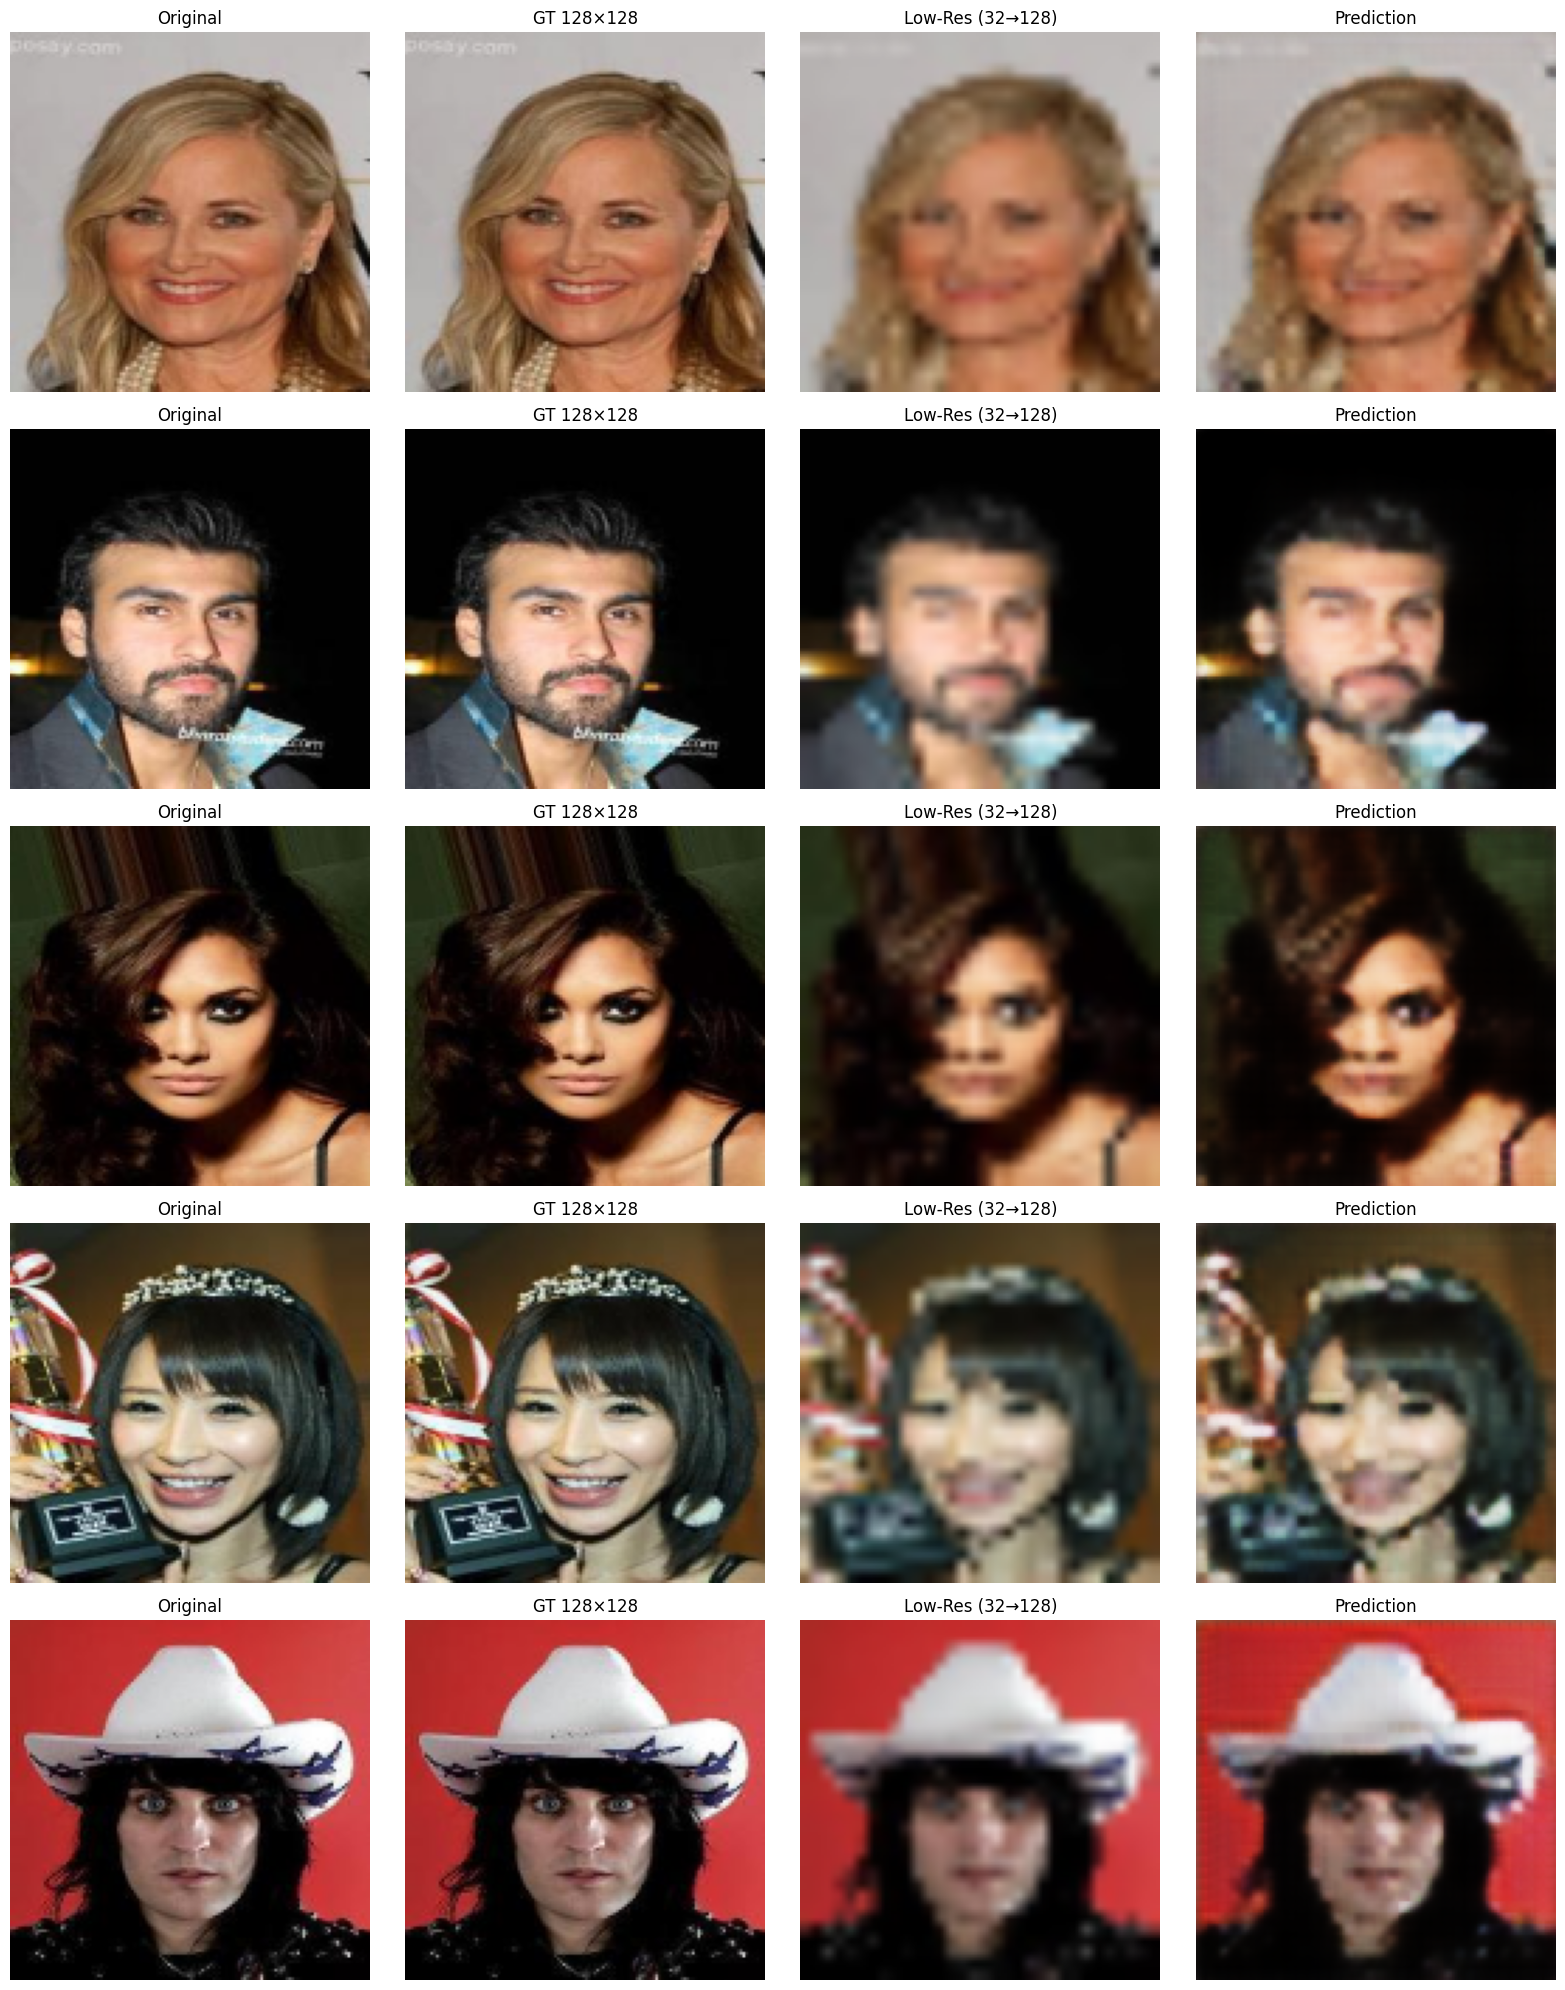

6331/6331 ━━━━━━━━━━━━━━━━━━━━ 2388s 377ms/step - loss: 0.0339
Epoch 3/3
6331/6331 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - loss: 0.0336
Epoch 3 samples:


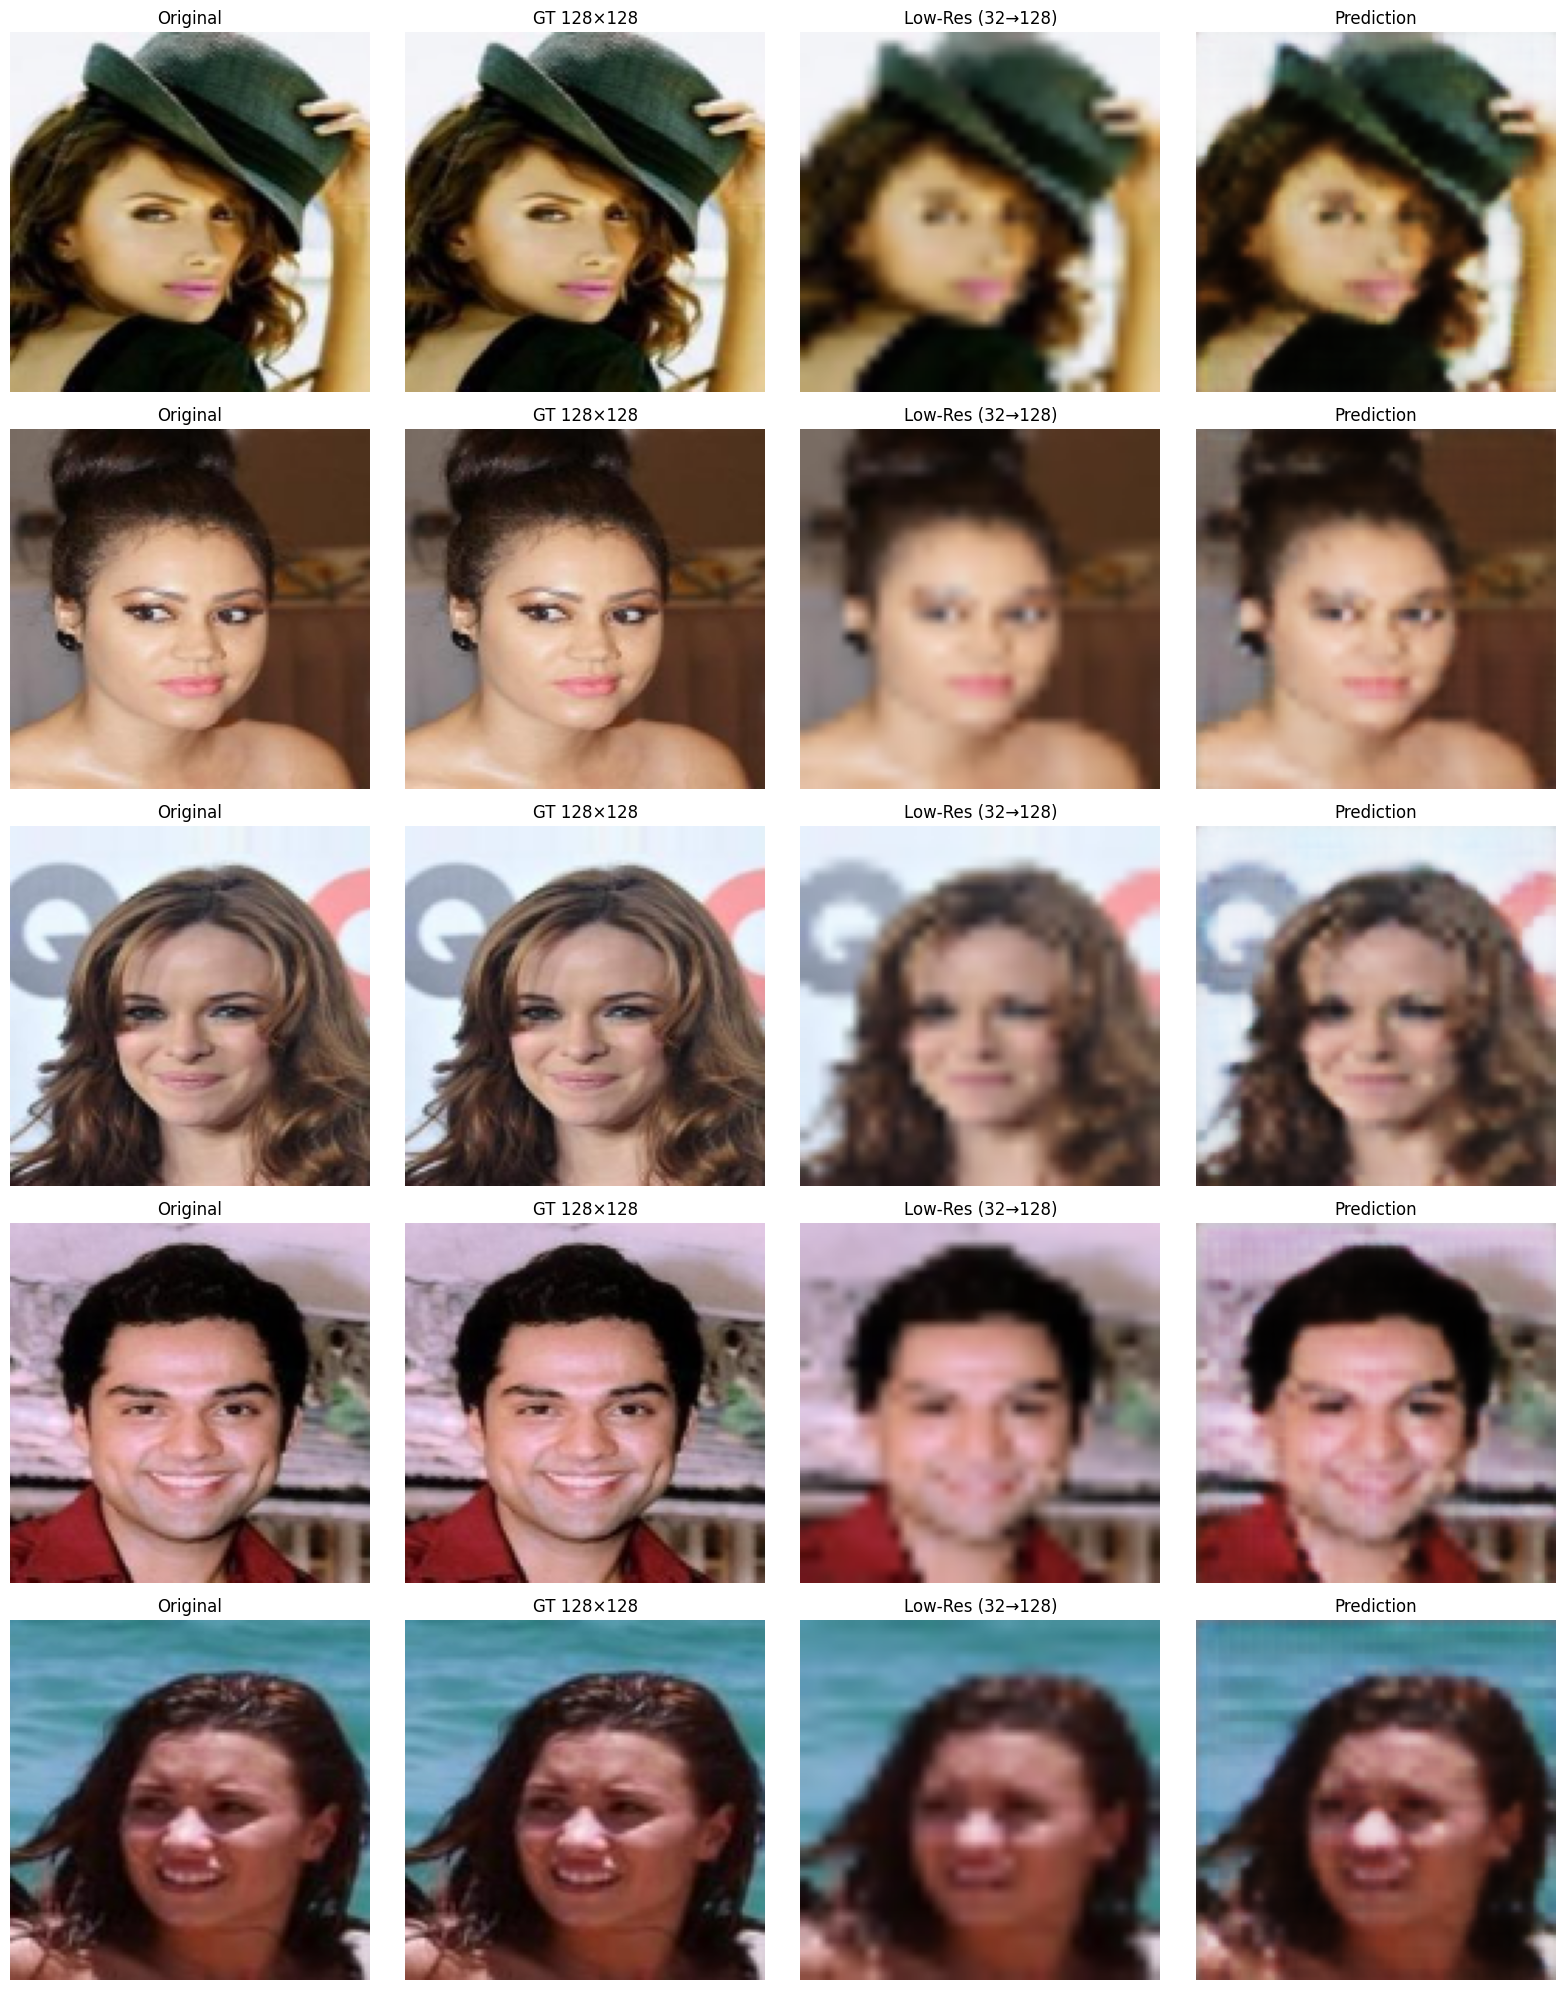

6331/6331 ━━━━━━━━━━━━━━━━━━━━ 2364s 373ms/step - loss: 0.0336


In [18]:
def on_epoch_end(epoch, logs):
    print(f"\nEpoch {epoch+1} samples:")
    show_samples(model)

callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=on_epoch_end)

model.fit(
    datagen(batch_size),
    steps_per_epoch=steps_per_epoch,
    epochs=3,
    callbacks=[callback],
    verbose=1
)


In [21]:
model.save("unet_32to128_super_resolution.keras")


## Project Summary

This project implemented a U-Net based image super-resolution model that converts
low-resolution **32×32 RGB images into high-resolution 128×128 images**.

- Dataset: CelebA
- Architecture: U-Net with skip connections
- Loss Function: Mean Absolute Error (MAE)
- Optimizer: Adam

The model successfully learns to reconstruct higher-resolution images, and visual
results show progressive improvement across epochs.

This approach demonstrates the effectiveness of encoder-decoder architectures for
image super-resolution tasks.
